# Предсказание температуры стали

## Загрузка библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error


## Анализ данных

Выводим данные об электродах:

In [2]:
#Функция вывода общей инфы
def data_info(data):
    print('Размер датасета:',data.shape)
    display(data.head())
    tab = pd.concat([data.dtypes, data.isna().mean()*100], axis=1)
    tab.columns=['data_type', 'nan_part, %']
    display(tab.sort_values(by='nan_part, %', ascending=False))
    display(data.describe())

In [3]:
data1 = pd.read_csv('/datasets/final_steel/data_arc.csv')

In [4]:
data_info(data1)

Размер датасета: (14876, 5)


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397


,data_type,"nan_part, %"
key,int64,0.0
Начало нагрева дугой,object,0.0
Конец нагрева дугой,object,0.0
Активная мощность,float64,0.0
Реактивная мощность,float64,0.0


,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.670441,0.452592
std,934.571502,0.408159,5.878702
min,1.000000,0.030002,-715.504924
25%,806.000000,0.395297,0.290991
50%,1617.000000,0.555517,0.415962
75%,2429.000000,0.857034,0.637371
max,3241.000000,3.731596,2.676388


In [5]:
data1[data1['Реактивная мощность'] < 0]

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
9780,2116,2019-07-24 00:44:48,2019-07-24 00:46:37,0.495782,-715.504924


Учитывая, что строка с отрицательным значением только одна, делаем вывод, что перед нами аномалия, которая связана либо с зависанием системы, либо с поломкой датчика определения реактивной мощности. Данные строки исключим из анализа.
Далее построим диграммы размаха для активной и реактивной мощностей, а также рассмотрим взаимосвязь между ними:

Text(0.5, 1.0, 'Диаграмма размаха активной мощности')

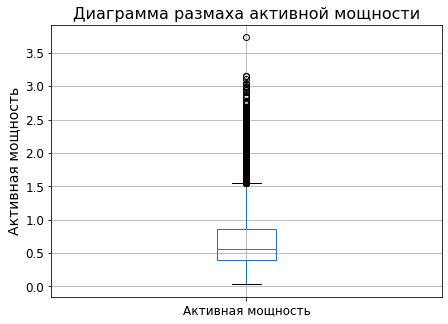

In [6]:
data1['Активная мощность'].plot(grid = True, 
                                   style = 'o', 
                                   figsize = (7, 5), 
                                   kind= 'box', 
                                   subplots = True, 
                                   fontsize=12)
plt.ylabel("Активная мощность", fontsize=14)
plt.title('Диаграмма размаха активной мощности', fontsize=16)

Text(0.5, 1.0, 'Диаграмма размаха реактивной мощности')

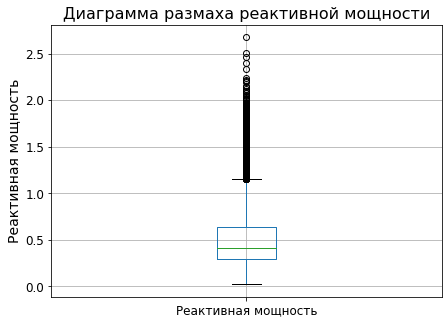

In [7]:
data1[data1['Реактивная мощность'] >= 0]['Реактивная мощность'].plot(grid = True, 
                                                                           style = 'o', 
                                                                           figsize = (7, 5), 
                                                                           kind= 'box', 
                                                                           subplots = True, 
                                                                           fontsize=12)
plt.ylabel("Реактивная мощность", fontsize=14)
plt.title('Диаграмма размаха реактивной мощности', fontsize=16)

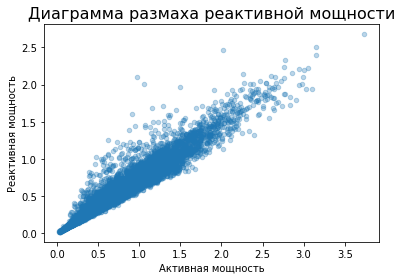

In [8]:
data1[data1['Реактивная мощность'] >= 0].plot(x='Активная мощность', 
                                                    y='Реактивная мощность', 
                                                    kind='scatter', alpha=0.3)
plt.title('Диаграмма размаха реактивной мощности', fontsize=16)
plt.show()

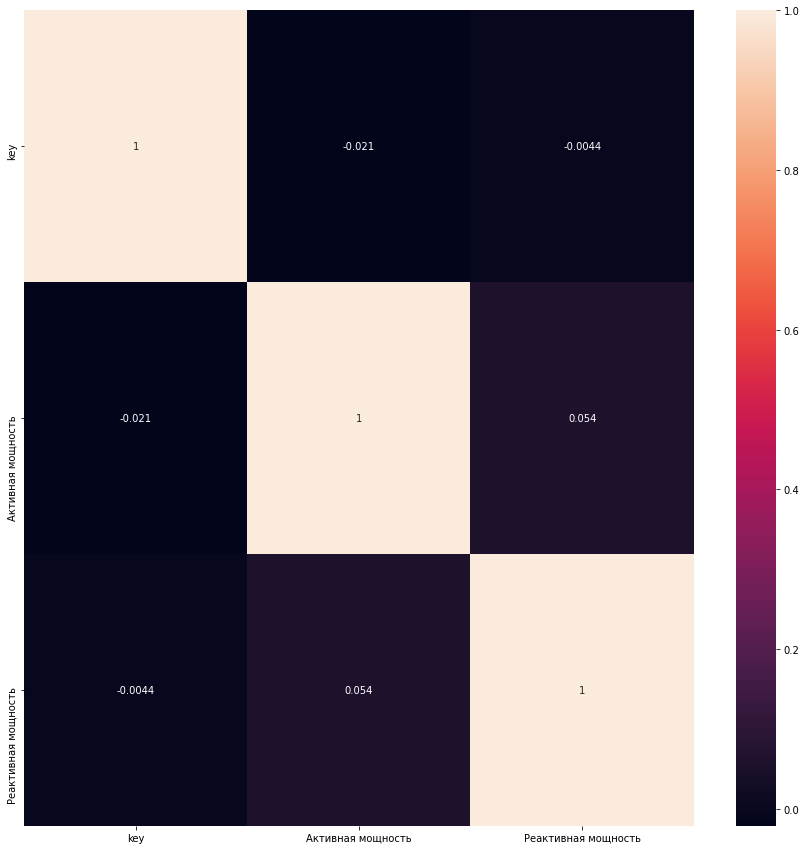

In [9]:
correlation_mat = data1.corr()

plt.subplots(figsize=(15,15)) 
sns.heatmap(correlation_mat, annot = True)

plt.show()

Данные параметры сильно коррелируют. В дальнейшем следует объеденить их в один параметр Полная мощность (https://ru.wikipedia.org/wiki/Электрическая_мощность). Выбросы не критичны и вероятно связаны с различным временем, необходимым для получения нужного хим.состава при использовании разных легирующих элементов в зависимости от технологического процесса (предположение: так как некоторые техпроцессы используются чаще, чем другие, следовательно и выбросы соответствуют тем, что используются реже).Данное предположение проверим на этапе формирования признаков для построения модели

Данные о подаче сыпучих материалов (объём):

In [10]:
data2 = pd.read_csv('/datasets/final_steel/data_bulk.csv')


In [11]:
data_info(data2)

Размер датасета: (3129, 16)


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


,data_type,"nan_part, %"
Bulk 8,float64,99.968041
Bulk 13,float64,99.424736
Bulk 9,float64,99.392777
Bulk 2,float64,99.296900
Bulk 7,float64,99.201023
Bulk 5,float64,97.539150
Bulk 10,float64,94.375200
Bulk 11,float64,94.343241
Bulk 1,float64,91.946309
Bulk 6,float64,81.591563


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


Данные о подаче сыпучих материалов (время)

In [12]:
data3 = pd.read_csv('/datasets/final_steel/data_bulk_time.csv')


In [13]:
data_info(data3)

Размер датасета: (3129, 16)


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56


,data_type,"nan_part, %"
Bulk 8,object,99.968041
Bulk 13,object,99.424736
Bulk 9,object,99.392777
Bulk 2,object,99.296900
Bulk 7,object,99.201023
Bulk 5,object,97.539150
Bulk 10,object,94.375200
Bulk 11,object,94.343241
Bulk 1,object,91.946309
Bulk 6,object,81.591563


,key
count,3129.000000
mean,1624.383509
std,933.337642
min,1.000000
25%,816.000000
50%,1622.000000
75%,2431.000000
max,3241.000000


Пропуски есть. Пропуски соответствуют тому факту, что сыпучий материал в расплав не добавлялся, можем заменить их нулями. В дальнейшем следует создать параметр **Суммарнное колличество подач сыпучих материалов** и **Объем добавленных материалов**. Типы данных меняем для приведения времени в нужный формат. Для всех сыпучих материалов среднее примерно соответствует медиане, что говорит о нормальном распределении данных. 

Данные о продувке сплава газом:

In [14]:
data4 = pd.read_csv('/datasets/final_steel/data_gas.csv')

In [15]:
data_info(data4)

Размер датасета: (3239, 2)


,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


,data_type,"nan_part, %"
key,int64,0.0
Газ 1,float64,0.0


,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


Пропусков нет, типы данных менять не нужно. Среднее примерно соответствует медиане, что говорит о нормальном распределении данных.

Результаты измерения температуры:

In [16]:
data5 = pd.read_csv('/datasets/final_steel/data_temp.csv')

In [17]:
data_info(data5)

Размер датасета: (15907, 3)


,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0


,data_type,"nan_part, %"
Температура,float64,18.237254
key,int64,0.000000
Время замера,object,0.000000


,key,Температура
count,15907.000000,13006.000000
mean,1607.880870,1591.840920
std,942.212073,21.375851
min,1.000000,1191.000000
25%,790.000000,1581.000000
50%,1618.000000,1591.000000
75%,2427.000000,1601.000000
max,3241.000000,1705.000000


Есть пропуски. Для времени необходимо поменять тип данных. Среднее примерно равно медиане, что говорит о нормальном распределении данных.

Text(0.5, 1.0, 'Диаграмма размаха температуры')

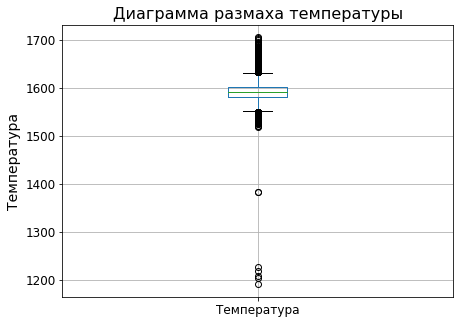

In [18]:
data5['Температура'].plot(grid = True, 
                       style = 'o',
                       figsize = (7, 5), 
                       kind= 'box', 
                       subplots = True, 
                       fontsize=12)
plt.ylabel("Температура", fontsize=14)
plt.title('Диаграмма размаха температуры', fontsize=16)

Обратим внимание на температуру меньше 1500С

In [19]:
keys = data5[data5['Температура'] < 1500]['key']
temp = []
for i in keys:
    temp.append(data5[data5['key'] == i])
temp

[      key         Время замера  Температура
 4350  867  2019-06-04 14:21:00       1191.0
 4351  867  2019-06-04 14:29:35       1575.0
 4352  867  2019-06-04 14:30:29       1576.0
 4353  867  2019-06-04 14:43:10       1571.0
 4354  867  2019-06-04 14:52:54       1600.0
 4355  867  2019-06-04 14:57:17       1599.0,
        key         Время замера  Температура
 5978  1214  2019-06-16 05:32:00       1208.0
 5979  1214  2019-06-16 05:49:01       1608.0
 5980  1214  2019-06-16 05:51:28       1608.0
 5981  1214  2019-06-16 05:51:38       1608.0
 5982  1214  2019-06-16 05:52:41       1608.0
 5983  1214  2019-06-16 05:53:03       1608.0
 5984  1214  2019-06-16 05:53:13       1608.0
 5985  1214  2019-06-16 05:54:48       1604.0
 5986  1214  2019-06-16 05:57:21       1604.0
 5987  1214  2019-06-16 06:00:25       1604.0
 5988  1214  2019-06-16 06:06:12       1600.0
 5989  1214  2019-06-16 06:07:28       1596.0
 5990  1214  2019-06-16 06:08:28       1596.0
 5991  1214  2019-06-16 06:09:10       1

Выбросы в районе 1200-1400С соответствуют логике, если печи только запускаются в работу, в следствие чего нужно время на нагрев и расплавку чугуна, из которого после получают сталь. Данный сценарий наблюдается в 4-х случаях из 6-ти примерно с одинаковой периодичностью. Данный вопрос следует уточнить у заказчика, для моделирования данные плавки не подходят. Температура плавления чугуна - 1150С (https://ru.wikipedia.org/wiki/Чугун#:~:text=Температура%20плавления%20чугуна%20—%20от,ниже%2C%20чем%20у%20чистого%20железа), а по заданию у нас сразу используется сталь. Для стали диапазон температур от 1350С до 1750С соответствует норме (https://ru.wikipedia.org/wiki/Сталь#:~:text=Температура%20плавления%3A%201450—1520%20°C.%20Удельная,кДж%2Fкг%20(20%20ккал%2Fкг%2C%2023%20Вт·ч%2Fкг)), однако все зависит от самой стали.

In [20]:
data5[data5['Температура'].isna()]

,key,Время замера,Температура
12268,2500,2019-08-06 03:24:43,NaN
12269,2500,2019-08-06 03:25:16,NaN
12270,2500,2019-08-06 03:28:21,NaN
12272,2501,2019-08-06 04:01:59,NaN
12273,2501,2019-08-06 04:14:35,NaN
...,...,...,...
15901,3240,2019-09-01 03:35:16,NaN
15903,3241,2019-09-01 04:16:12,NaN
15904,3241,2019-09-01 04:22:39,NaN
15905,3241,2019-09-01 04:33:42,NaN


Отсутствуют данные для измерения температуры с 2500-й партии. Вероятно, данные находятся на проверке и ещё не загружены в систему, либо произошёл сбой (поломка) в работах датчиков. В любом случае, данные с 2500-й партии для построения модели не подойдут. Учитывая, что температура - целевой признак, но измерений для партии несколько, следует брать за целевое значение последний замер, так как он делается после всех операций тех.процесса получения стали.

Данные о проволочных материалах (объём):

In [21]:
data6 = pd.read_csv('/datasets/final_steel/data_wire.csv')

In [22]:
data_info(data6)

Размер датасета: (3081, 10)


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,data_type,"nan_part, %"
Wire 5,float64,99.967543
Wire 7,float64,99.642973
Wire 4,float64,99.545602
Wire 8,float64,99.383317
Wire 9,float64,99.058747
Wire 3,float64,97.955209
Wire 6,float64,97.630639
Wire 2,float64,64.978903
Wire 1,float64,0.843882
key,int64,0.000000


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


Данные о проволочных материалах (время):

In [23]:
data7 = pd.read_csv('/datasets/final_steel/data_wire_time.csv')

In [24]:
data_info(data7)

Размер датасета: (3081, 10)


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,data_type,"nan_part, %"
Wire 5,object,99.967543
Wire 7,object,99.642973
Wire 4,object,99.545602
Wire 8,object,99.383317
Wire 9,object,99.058747
Wire 3,object,97.955209
Wire 6,object,97.630639
Wire 2,object,64.978903
Wire 1,object,0.843882
key,int64,0.000000


,key
count,3081.000000
mean,1623.426485
std,932.996726
min,1.000000
25%,823.000000
50%,1619.000000
75%,2434.000000
max,3241.000000


Пропуски есть. Пропуски соответствуют тому факту, что сыпучий материал в расплав не добавлялся, можем заменить их нулями. В дальнейшем следует создать параметр **Суммарнное колличество подач проволочных материалов** и **Суммарный объем добавленных материалов**. Типы данных меняем для приведения времени в нужный формат. Для всех проволочных материалов среднее примерно соответствует медиане, что говорит о нормальном распределении данных. 

**Вывод:**

1) Для data_arc найденно аномальное отрицательное значение. Плавка №2116, в которой оно присутствует, необходимо исключить из дальнейшей работы. Плавки с температурой ниже 1400С тоже необходимо исключить до внесения ясности от заказчика. При этом параметры реактивная и активная мощности необходимо объеденить в один - полную мощность. Далее при умножении на время получить признак Работа;

2) Пропуски в датасетах, касающихся материалов,соответствуют факту, что материалы в расплав не добавлялись, поэтому их можно заменить нулями. При этом следует создать суммарные параметры и далее исключить из построения модели параметры с сильной корреляцией;

3) За целевой признак необходимо брать последний температурный замер, так как он делается после всех операций тех.процесса получения стали;

4) Необходимо поменять тип данных для времени в датасетах;

# план действий:

1) Привести данные к нужными типам;

2) Избавиться от выбрасов, что могут пагубно влиять на обучение модели;

3) Объединить данные начав с температурного и сета по электродам;

4) Проработать получившийся сет;

5) Разделить данные на тестову, валидационную и обучающую;

6) Обучить модели;

7) Выбрать оптимальную модель из полученных результатов работы.

## Предобработка данных

In [25]:
def data_typ(dat, stolb):
    dat[stolb] = pd.to_datetime(dat[stolb], format = '%Y-%m-%d %H:%M:%S')
    dat.info()

Исключаем из выборки найденные нами ранее отрицательные мощности

In [26]:
data1 = data1.query('key != 2116')

In [27]:
columns = ['Начало нагрева дугой', 'Конец нагрева дугой']

for i in columns:
    data_typ(data1, i)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14872 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   key                   14872 non-null  int64         
 1   Начало нагрева дугой  14872 non-null  datetime64[ns]
 2   Конец нагрева дугой   14872 non-null  object        
 3   Активная мощность     14872 non-null  float64       
 4   Реактивная мощность   14872 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(1)
memory usage: 697.1+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 14872 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   key                   14872 non-null  int64         
 1   Начало нагрева дугой  14872 non-null  datetime64[ns]
 2   Конец нагрева дугой   14872 non-null  datetime64[ns]
 3   

Вычислим полную мощность, время нагрева и работу:

In [28]:
data1['Время нагрева в сек'] = (data1['Конец нагрева дугой'] - data1['Начало нагрева дугой']).dt.seconds

In [29]:
data1['Полная мощность'] = (data1['Активная мощность']**2 + data1['Реактивная мощность']**2) ** 0.5
data1['Работа'] = round(data1['Полная мощность']*data1['Время нагрева в сек'], 2)
data1.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Время нагрева в сек,Полная мощность,Работа
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,228,1.193639,272.15
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,185,0.959010,177.42
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,172,0.896038,154.12
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,365,1.970470,719.22
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,148,0.807239,119.47


In [30]:
pv_duga=data1.pivot_table(index = ['key'], values = ['Работа'], aggfunc = [sum, len])
pv_duga.head()

,sum,len
,Работа,Работа
key,,
1,1442.38,5.0
2,881.23,4.0
3,525.07,5.0
4,796.92,4.0
5,1199.13,4.0


In [31]:
pv_duga.columns=['work','steps']

Конечные признаки для первого сета выглядят так:

In [32]:
pv_duga.head()

,work,steps
key,,
1,1442.38,5.0
2,881.23,4.0
3,525.07,5.0
4,796.92,4.0
5,1199.13,4.0


In [33]:
pv_duga.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3213 entries, 1 to 3241
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   work    3213 non-null   float64
 1   steps   3213 non-null   float64
dtypes: float64(2)
memory usage: 75.3 KB


Для следующего сета данных в качестве признаков используем суммарный объём сыпучих материалов и колличество их подач:

In [34]:
data_bulk = data2.set_index('key')
data_bulk['count_bulk'] = data_bulk.count(axis=1)
data_bulk
data_bulk['sum_bulk'] = data_bulk[data_bulk.drop('count_bulk', axis=1).columns].sum(axis=1)
data_bulk_act = data_bulk[['sum_bulk', 'count_bulk']]
data_bulk_act.head()

,sum_bulk,count_bulk
key,,
1,553.0,4
2,582.0,4
3,544.0,4
4,595.0,4
5,584.0,4


Так же и с проволочными материалами:

In [35]:
data_wire = data6.set_index('key')
data_wire['count_wire'] = data_wire.count(axis=1)
data_wire
data_wire['sum_wire'] = data_wire[data_wire.drop('count_wire', axis=1).columns].sum(axis=1)
data_wire_act = data_wire[['sum_wire', 'count_wire']]
data_wire_act.head()

,sum_wire,count_wire
key,,
1,60.059998,1
2,96.052315,1
3,91.160157,1
4,89.063515,1
5,98.352796,2


Обработаем данные по газу:

In [36]:
data_gas = data4.set_index('key').rename(columns={'Газ 1':'gas'})
data_gas.head()

,gas
key,
1,29.749986
2,12.555561
3,28.554793
4,18.841219
5,5.413692


Займемся ключевыми данными, а именно температурными замерами:

In [37]:
data5.head()

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0


In [38]:
data5.isna().sum()

key                0
Время замера       0
Температура     2901
dtype: int64

Из всех измерений температуры оставляем только первое и последнее. Исключаем все плавки с 2500-й(данные в них отсутствуют) и далее и все плавки с начальной температурой < 1400С

In [39]:
data_temp = (data5.groupby('key')['Температура']
                      .agg(['first', 'last']).loc[:2499])
data_temp = data_temp.rename(columns={'first':'init_temp', 'last':'last_temp'})
data_temp = data_temp.query('init_temp > 1400') 
data_temp.head(5)

,init_temp,last_temp
key,,
1,1571.0,1613.0
2,1581.0,1602.0
3,1596.0,1599.0
4,1601.0,1625.0
5,1576.0,1602.0


In [40]:
data_temp.shape

(2473, 2)

**Объеденим полученные данные:**

Временные данные по подаче сыпущик и проволочных материалов в итоговую таблицу не влючаем, так как их время подачи для данной задачи значения не имеет

In [41]:
df = (
    data_temp
    .join(pv_duga)
    .join(data_bulk_act)
    .join(data_wire_act)
    .join(data_gas)
    )
print(df.shape)
display(df.sample(10))
display(df.describe())

(2473, 9)


,init_temp,last_temp,work,steps,sum_bulk,count_bulk,sum_wire,count_wire,gas
key,,,,,,,,,
2297,1579.0,1582.0,426.19,3.0,360.0,2.0,14.021279,1.0,9.658626
1417,1559.0,1575.0,953.41,4.0,987.0,6.0,148.209358,2.0,8.855217
696,1629.0,1598.0,248.14,5.0,616.0,4.0,134.128799,1.0,22.234399
2329,1586.0,1600.0,1227.81,3.0,553.0,4.0,114.048477,1.0,6.899465
1269,1627.0,1584.0,1181.26,9.0,1173.0,4.0,425.145752,2.0,20.882042
667,1586.0,1602.0,754.35,5.0,915.0,4.0,129.214798,1.0,9.115819
1792,1633.0,1603.0,147.32,2.0,19.0,1.0,86.018402,1.0,5.154943
1587,1531.0,1581.0,1652.63,5.0,531.0,3.0,198.296795,2.0,10.311039
204,1603.0,1591.0,526.03,6.0,933.0,4.0,154.539832,2.0,12.104109


,init_temp,last_temp,work,steps,sum_bulk,count_bulk,sum_wire,count_wire,gas
count,2473.000000,2473.000000,2470.000000,2470.000000,2404.000000,2404.000000,2369.000000,2369.000000,2471.000000
mean,1589.016175,1595.338051,904.993146,4.626721,603.866057,3.545341,125.248227,1.400169,11.139788
std,24.996127,16.031388,655.651432,1.609741,287.210515,1.242214,64.043741,0.566759,6.328796
min,1519.000000,1541.000000,15.160000,1.000000,19.000000,1.000000,1.918800,1.000000,0.008399
25%,1572.000000,1587.000000,461.407500,4.000000,430.000000,3.000000,88.272080,1.000000,7.102961
50%,1588.000000,1593.000000,768.745000,4.000000,604.000000,4.000000,116.101440,1.000000,9.925930
75%,1605.000000,1599.000000,1170.257500,6.000000,789.000000,4.000000,151.625755,2.000000,13.872453
max,1679.000000,1700.000000,10630.970000,16.000000,3235.000000,7.000000,568.777664,5.000000,77.995040


Данные логичны, отрицательные значения отсутствуют

In [42]:
df.isnull().sum()

init_temp       0
last_temp       0
work            3
steps           3
sum_bulk       69
count_bulk     69
sum_wire      104
count_wire    104
gas             2
dtype: int64

sum_bulk, count_bulk, sum_wire, count_wire, gas пропуски в этих столбцах говорят о том, что подачи не было, заменим их нулями

Посмотрим на пропуски по работе:

In [43]:
df[df['work'].isnull()]

,init_temp,last_temp,work,steps,sum_bulk,count_bulk,sum_wire,count_wire,gas
key,,,,,,,,,
195,1583.0,1583.0,NaN,NaN,NaN,NaN,NaN,NaN,0.374436
279,1603.0,1603.0,NaN,NaN,89.0,1.0,99.066236,1.0,7.232359
2116,1579.0,1578.0,NaN,NaN,335.0,2.0,75.216965,1.0,11.582547


Все логично, температура не изменилась = нет работы, заменяем нулями 

In [44]:
df = df.fillna(0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2473 entries, 1 to 2499
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   init_temp   2473 non-null   float64
 1   last_temp   2473 non-null   float64
 2   work        2473 non-null   float64
 3   steps       2473 non-null   float64
 4   sum_bulk    2473 non-null   float64
 5   count_bulk  2473 non-null   float64
 6   sum_wire    2473 non-null   float64
 7   count_wire  2473 non-null   float64
 8   gas         2473 non-null   float64
dtypes: float64(9)
memory usage: 257.7 KB


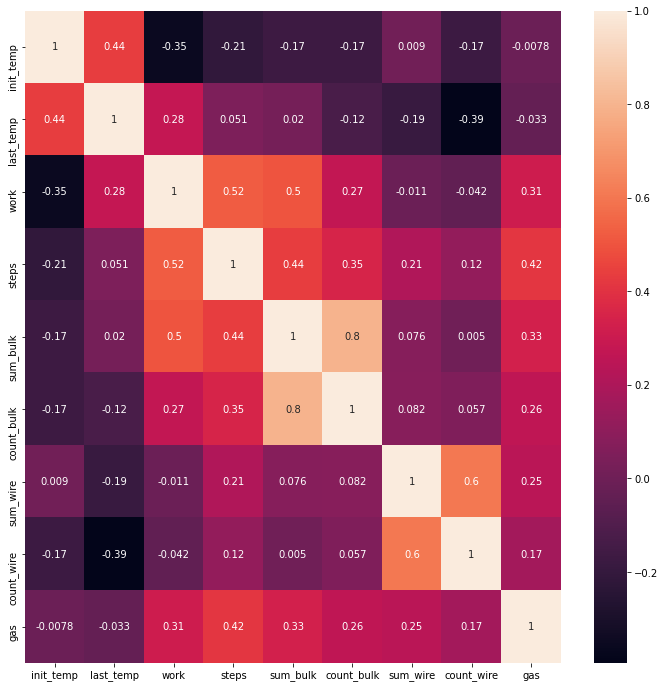

In [45]:
plt.figure(figsize=(12, 12))
sns.heatmap(df.corr(), annot=True)
plt.show()

Объем материалов коррелирует с количеством шагов, начальная температура коррелирует с конечной. Данные выглядят логично.

## Построение моделей

Выделяем целевой признак, делим на выборки

In [46]:
target = df['last_temp']
features = df.drop('last_temp', axis=1)
features_train, features_test, target_train, target_test = train_test_split(features, 
                                                                            target, 
                                                                            test_size = 0.25, 
                                                                            random_state = 12345)

Приступим к построению моделей. Для работы выбраны следующие модели: линейная регрессия, случайный лес, XGBoost, CatBoost

**Линейная регрессия**

In [47]:
model = LinearRegression()
model.fit(features_train, target_train)
result = model.predict(features_test)
linreg_score = mean_absolute_error(target_test, result)
print('Test MAE=', linreg_score)

Test MAE= 7.843746993169326


Минимум достигнут.

**Случайный лес**

In [48]:
#диапазон параметров уменьшен по результатам предыдущих моделирований с целью сокращения времени моделирования
model = RandomForestRegressor()
params = {
    'n_estimators':[x for x in range(490, 491, 1)],
    'max_depth':[x for x in range(188, 189, 1)], 
    'min_samples_leaf':[x for x in range(1, 2, 1)],
    'min_samples_split':[x for x in range(14, 15, 1)],
}
grid = RandomizedSearchCV(model, 
                          params,  
                          n_iter = 10, 
                          random_state = 12345, 
                          cv = 5)
grid.fit(features_train, target_train)
result = grid.predict(features_test)
forest_score = mean_absolute_error(target_test, result)
print('Лучшие параметры:', grid.best_params_)
print('Test MAE=', forest_score)

Лучшие параметры: {'n_estimators': 490, 'min_samples_split': 14, 'min_samples_leaf': 1, 'max_depth': 188}
Test MAE= 6.282193516221786


**XGBoost**

In [49]:
model = XGBRegressor(
    n_estimators = 1500,
    learning_rate = 0.008,
    reg_alpha = 15,
    objective = 'reg:squarederror',
    random_state = 12345
)
model.fit(features_train, target_train)

result = model.predict(features_test)
xgb_score = mean_absolute_error(target_test, result)
print('Test MAE=', xgb_score)

Test MAE= 6.129142107986672


**CatBoost**

In [50]:
model = CatBoostRegressor(
    loss_function='MAE', 
    random_state = 12345, 
    iterations = 1500, 
    learning_rate = 0.008, 
    l2_leaf_reg = 50,
    )
model.fit(features_train, target_train, verbose = 100)

result = model.predict(features_test)
cb_score = mean_absolute_error(target_test, result)
print('\nTest MAE =', cb_score)

0:	learn: 10.0728577	total: 48.3ms	remaining: 1m 12s
100:	learn: 8.1991110	total: 180ms	remaining: 2.49s
200:	learn: 7.2387555	total: 313ms	remaining: 2.02s
300:	learn: 6.7196259	total: 443ms	remaining: 1.76s
400:	learn: 6.4100239	total: 583ms	remaining: 1.6s
500:	learn: 6.1888288	total: 719ms	remaining: 1.43s
600:	learn: 6.0174456	total: 851ms	remaining: 1.27s
700:	learn: 5.8763616	total: 980ms	remaining: 1.12s
800:	learn: 5.7575235	total: 1.11s	remaining: 966ms
900:	learn: 5.6455733	total: 1.23s	remaining: 821ms
1000:	learn: 5.5380546	total: 1.36s	remaining: 678ms
1100:	learn: 5.4442911	total: 1.49s	remaining: 539ms
1200:	learn: 5.3478785	total: 1.61s	remaining: 402ms
1300:	learn: 5.2540114	total: 1.74s	remaining: 266ms
1400:	learn: 5.1702703	total: 1.86s	remaining: 132ms
1499:	learn: 5.0937632	total: 1.99s	remaining: 0us

Test MAE = 6.00317560257021


**Фикция**

In [51]:
dummy_pred = pd.Series(target_train.mean(), index=target_test.index)
dummy_result = mean_absolute_error(target_test, dummy_pred)
print('Dummy MAE =', dummy_result)

Dummy MAE = 9.746945433442612


Видно, что у всех моделей показатель MAE выше, чем у Фиктивной - это говорит о том, что они работают как нужно.

In [52]:
(
    pd.Series(
    data=[linreg_score, forest_score, xgb_score, cb_score, dummy_result],
    index=['LinearRegression', 'RandomForest', 'XGBoost', 'CatBoost', 'Dummy_mean'],
    name='MAE_score'
    )
    .sort_values()
    .to_frame()
)

,MAE_score
CatBoost,6.003176
XGBoost,6.129142
RandomForest,6.282194
LinearRegression,7.843747
Dummy_mean,9.746945


Как видно из результатов наилучший показаль у модели CatBoost с МАЕ = 6.01.

Рассмотрим важность признаков в лучшей модели:

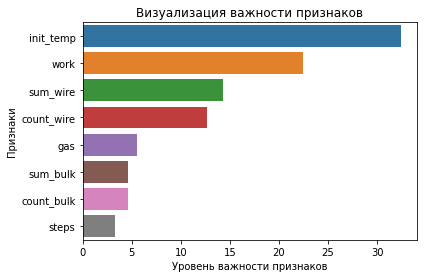

In [53]:
def validate_the_importance(model):
    feature_importance = pd.Series(model.feature_importances_, index = features_test.columns).sort_values(ascending=False)

    ax = sns.barplot(x = feature_importance, y = feature_importance.index)
    _ = ax.set(xlabel='Уровень важности признаков', ylabel = 'Признаки')
    _ = ax.set_title('Визуализация важности признаков')

validate_the_importance(model)

Наибольшее влияние на конечную температу оказывает начальная температура - чем больше разница, тем больше нужно нагревать.2-й признак по важности - работа: чем она больше, тем больше энергии идёт на нагрев - логично. Далее следует кол-во проволочных материалов. Видим, что использовать проволоку гораздо энергозатратнее, чем сыпучие материалы. В целях оптимизации расходов заказчику следует обратить внимание на начальную температуру расплава и найти альтернативу материалам в виде проволоки,если это возможно. 

Так как колличество нагревов и колличество добавлений сыпучих материалов оказывают низкое влияние на модель, попробуем убрать их с целью упрощения работы модели:

In [54]:
target_new = df['last_temp']
features_new = df.drop(['last_temp','steps','count_bulk'], axis=1)
features_train_n, features_test_n, target_train_n, target_test_n = train_test_split(features_new, 
                                                                            target_new, 
                                                                            test_size = 0.25, 
                                                                            random_state = 12345)

In [55]:
model = CatBoostRegressor(
    loss_function='MAE', 
    random_state = 12345, 
    iterations = 1500, 
    learning_rate = 0.008, 
    l2_leaf_reg = 50,
    )
model.fit(features_train_n, target_train_n, verbose = 100)

result = model.predict(features_test_n)
cb_score = mean_absolute_error(target_test_n, result)
print('\nTest MAE =', cb_score)

0:	learn: 10.0731986	total: 2.12ms	remaining: 3.18s
100:	learn: 8.1717186	total: 134ms	remaining: 1.85s
200:	learn: 7.2113449	total: 260ms	remaining: 1.68s
300:	learn: 6.7100535	total: 388ms	remaining: 1.54s
400:	learn: 6.4126733	total: 511ms	remaining: 1.4s
500:	learn: 6.2042569	total: 635ms	remaining: 1.27s
600:	learn: 6.0453499	total: 759ms	remaining: 1.14s
700:	learn: 5.9112334	total: 881ms	remaining: 1s
800:	learn: 5.8017580	total: 1s	remaining: 876ms
900:	learn: 5.6959756	total: 1.12s	remaining: 748ms
1000:	learn: 5.6035321	total: 1.25s	remaining: 624ms
1100:	learn: 5.5153703	total: 1.38s	remaining: 499ms
1200:	learn: 5.4277859	total: 1.51s	remaining: 375ms
1300:	learn: 5.3481347	total: 1.63s	remaining: 249ms
1400:	learn: 5.2729865	total: 1.75s	remaining: 124ms
1499:	learn: 5.2042506	total: 1.88s	remaining: 0us

Test MAE = 5.945579896272309


Улучшился показатель и уменьшилось общее колличество затраченного времени, думаю цель достигнута.

# Отчет по проделанной работе

В процессе работы над проектом были в полном объёме выполнены все пункты плана: проведена предобработка данных и подготовлена таблица с признаками, построены 4 модели для прогнозирования температуры, выбрана лучшая модель, выполняющая поставленную задачу, для которой проведён анализ важности признаков;

В процессе работы над проектом возникали только вопросы, касающиеся предметной области - металлургии.

Из 4 построенных моделей в процессе сравнения наилучший результат показала модель градиентного бустинга CatBoost с МАЕ = 6.01.

В результате анализа важности признаков модели полученны следующие результаты: наибольшее влияние оказывают следующие факторы - начальная температура, кол-во затраченной работы и объём использованных проволочных материалов. Согласно имеющимся данным, рекомендую обратить внимание на уменьшение диапазона разброса начальной температуры, проанализировать оборудование на факт наличия утечек энергиии, ввести автомотическую фиксацию аномалий и всех сопутствующих производственных факторов для анализа с целью уменьшения будущих расходов.

С целью улучшения качества модели профильтровали признаки, отсеяв наименее важные. Новая модель градиентного бустинга CatBoost достигла показателя МАЕ = 5.94 и на порядок сократила расчетное время.